In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp

from common import PLOT_PARAMS, COLUMN_WIDTH
from ml4wifi.agents import BaseAgent
from ml4wifi.agents.kalman_filter import kalman_filter
from ml4wifi.envs.simple_wifi.ftmrate_sim import FRAMES_PER_SECOND, FIRST_MEASUREMENT_SHIFT
from ml4wifi.utils.measurement_manager import DEFAULT_INTERVAL, measurement_manager
from ml4wifi.utils.wifi_specs import *

tfb = tfp.bijectors
tfd = tfp.distributions

COLUMN_HIGHT = 2 * COLUMN_WIDTH / (1 + np.sqrt(5))
PLOT_WIDTH = 2 * COLUMN_WIDTH - COLUMN_HIGHT

In [2]:
SEED = 73
SIMULATION_TIME = 6
START_POSITION = 0.0
VELOCITY = 2.0

SAMPLE_SIZE = 1e5
COLOR_GRAY = "tab:gray"
COLOR_BLUE = "tab:blue"

## Aggregate distributions

In [3]:
key = jax.random.PRNGKey(SEED)
key, init_key = jax.random.split(key)
total_frames = int(FRAMES_PER_SECOND * SIMULATION_TIME)
time2frames = lambda time: jnp.int32(jnp.floor(FRAMES_PER_SECOND * time))

agent: BaseAgent = kalman_filter()
measurements_manager = measurement_manager(DEFAULT_INTERVAL)

time = jnp.linspace(0.0, SIMULATION_TIME, total_frames) + FIRST_MEASUREMENT_SHIFT
true_distance = jnp.linspace(0.0, VELOCITY * SIMULATION_TIME, total_frames) + START_POSITION

It may take a few minutes (~3 min), since no jax.jit() is applied...

In [4]:
distance_distribution_acc = []
distance_measured_acc = jnp.empty(total_frames)
sec_counter = 0
state = agent.init(init_key)
m_state = measurements_manager.init()
for frame_id in range(0, total_frames):

    key, noise_key, update_key, sample_key, results_key = jax.random.split(key, 5)

    m_state, measured = measurements_manager.update(m_state, true_distance[frame_id], time[frame_id], noise_key)
    state = jax.lax.cond(measured, lambda: agent.update(state, update_key, m_state.distance, time[frame_id]), lambda: state)

    distance_distribution_acc.append(agent.sample(state, sample_key, time[frame_id]))
    distance_measured_acc = distance_measured_acc.at[frame_id].set(m_state.distance)

    if frame_id % FRAMES_PER_SECOND == 0:
        print(f"Second {sec_counter} of {SIMULATION_TIME}...")
        sec_counter += 1


Second 0 of 6...
Second 1 of 6...
Second 2 of 6...
Second 3 of 6...
Second 4 of 6...
Second 5 of 6...


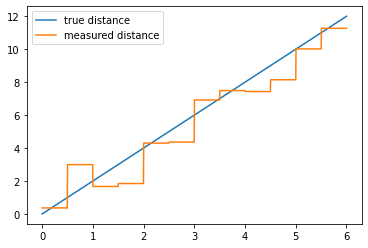

In [5]:
plt.plot(time, true_distance, label="true distance")
plt.plot(time, distance_measured_acc, label="measured distance")
plt.legend()

## Prepare data

Be sure to have every timestep dividable by *quant* -> it is important to synchronize boxplots

In [6]:
time_order = [40 + i for i in range(16)]
confidence_level = 0.95
alpha = 1 - confidence_level

m_timesteps = [4.0, 4.5, 5.0, 5.5]
m_mask = jnp.array(list(map(time2frames, m_timesteps)))

pred_timesteps = [4.6, 4.7, 4.8, 4.9]
pred_mask = jnp.array(list(map(time2frames, pred_timesteps)))
pred_constant_indeces = jnp.arange(time2frames(6.0), time2frames(6.5), 1, dtype=jnp.int32)

In [7]:
key, sample_key = jax.random.split(key)

m_distance_samples = list(map(lambda m: distance_distribution_acc[m].sample(sample_shape=SAMPLE_SIZE, seed=sample_key), m_mask))
m_distance_samples = jnp.concatenate(m_distance_samples, axis=0)
m_distance_samples = pd.DataFrame({
    "timestep": jnp.repeat(jnp.array(m_timesteps) * 10, int(SAMPLE_SIZE)).astype(jnp.int32),
    "samples": m_distance_samples,
    "category": jnp.ones_like(m_distance_samples)
})

pred_distance_samples = list(map(lambda p: distance_distribution_acc[p].sample(sample_shape=SAMPLE_SIZE, seed=sample_key), pred_mask))
pred_distance_samples = jnp.concatenate(pred_distance_samples, axis=0)
pred_distance_samples = pd.DataFrame({
    "timestep": jnp.repeat(jnp.array(pred_timesteps) * 10, int(SAMPLE_SIZE)).astype(jnp.int32),
    "samples": pred_distance_samples,
    "category": jnp.ones_like(pred_distance_samples)
})

## Plot data

In [8]:
# Configure common parameters
plt.rcParams.update(PLOT_PARAMS)
plt.rcParams.update({
    'figure.figsize': (2 * COLUMN_WIDTH, COLUMN_HIGHT),
    'legend.title_fontsize': 7,
    'legend.fontsize': 7
})

colors_viridis = pl.cm.viridis(jnp.linspace(0., 1., 5))[3:]
colors_jet = pl.cm.jet(jnp.linspace(0., 1., 12))
colors_gray = np.stack([np.array([0.5, 0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5, 0.5])])

ticks = jnp.array(sorted(m_timesteps + pred_timesteps))
n_points = 200

### Plot distance filtration and channel model

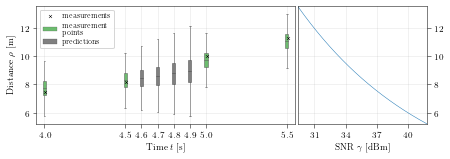

In [9]:
# Create and adjust figure
fig, axes = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [2, 1]})
fig.subplots_adjust(wspace=0.015)

# Plot boxes
axes[0].scatter((time[m_mask] - 4) * 10, distance_measured_acc[m_mask], color='k', marker='x', label="measurements", s=9)
sns.boxplot(
    x="timestep", y="samples", data=m_distance_samples, hue="category",
    order=time_order, ax=axes[0], width=0.2, palette=colors_viridis, showfliers=False
)
sns.boxplot(
    x="timestep", y="samples", data=pred_distance_samples, hue="category",
    order=time_order, ax=axes[0], width=0.2, palette=colors_gray, showfliers=False
)

# Configure labels
axes[0].set_xticks((ticks - 4) * 10)
axes[0].set_xticklabels(ticks)
axes[0].set_xlabel(r'Time $t$ [s]')
axes[0].set_ylabel(r'Distance $\rho$ [m]')
axes[0].set_ylim(5.2, 13.5)
axes[0].set_axisbelow(True)
axes[0].grid()
dist_ylim = axes[0].get_ylim()

# Modify legend
rates_legend = axes[0].get_legend_handles_labels()
axes[0].legend(rates_legend[0][:], ["measurements", "measurement\npoints", "predictions"])

# Calculate channel distance -> snr mapping
distance_to_snr_scalar = lambda distance: REFERENCE_SNR - (REFERENCE_LOSS + 10 * EXPONENT * jnp.log10(distance))
distance = jnp.linspace(dist_ylim[0], dist_ylim[1], 300)
snr = distance_to_snr_scalar(distance)

# Plot channel model
snr_ticks = [31., 34., 37., 40.]
axes[1].plot(snr, distance)
axes[1].set_xlabel(r'SNR $\gamma$ [dBm]')
axes[1].set_xticks(snr_ticks)
axes[1].set_ylim(dist_ylim)
axes[1].set_xlim(snr[-1], snr[0])
axes[1].tick_params('y', labelleft=False, left=False, labelright=True, right=True)
axes[1].set_axisbelow(True)
axes[1].grid()
snr_ylim = axes[1].get_xlim()

plt.savefig("distance_bars.pdf", bbox_inches='tight')

### Plot SNR filtration and data rates plots

In [10]:
key, sample_key = jax.random.split(key)

m_snr_samples = list(map(
    lambda m: distance_to_snr(tfb.Softplus()(distance_distribution_acc[m])).sample(sample_shape=SAMPLE_SIZE, seed=sample_key), 
    m_mask
))
m_snr_samples = jnp.concatenate(m_snr_samples, axis=0)
m_snr_samples = pd.DataFrame({
    "timestep": jnp.repeat(jnp.array(m_timesteps) * 10, int(SAMPLE_SIZE)).astype(jnp.int32),
    "samples": m_snr_samples,
    "category": jnp.ones_like(m_snr_samples)
})

pred_snr_samples = list(map(
    lambda p: distance_to_snr(tfb.Softplus()(distance_distribution_acc[p])).sample(sample_shape=SAMPLE_SIZE, seed=sample_key), 
    pred_mask
))
pred_snr_samples = jnp.concatenate(pred_snr_samples, axis=0)
pred_snr_samples = pd.DataFrame({
    "timestep": jnp.repeat(jnp.array(pred_timesteps) * 10, int(SAMPLE_SIZE)).astype(jnp.int32),
    "samples": pred_snr_samples,
    "category": jnp.ones_like(pred_snr_samples)
})

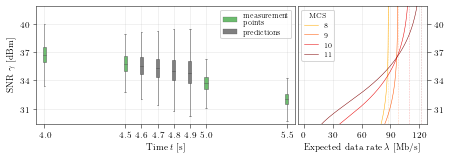

In [11]:
# Create and adjust figure
fig, axes = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [2, 1]})
fig.subplots_adjust(wspace=0.015)

# Plot boxes
sns.boxplot(
    x="timestep", y="samples", data=m_snr_samples, hue="category",
    order=time_order, ax=axes[0], width=0.2, palette=colors_viridis, showfliers=False
)
sns.boxplot(
    x="timestep", y="samples", data=pred_snr_samples, hue="category",
    order=time_order, ax=axes[0], width=0.2, palette=colors_gray, showfliers=False
)

# Configure labels
axes[0].set_xticks((ticks - 4) * 10)
axes[0].set_xticklabels(ticks)
axes[0].set_yticks(snr_ticks)
axes[0].set_xlabel(r'Time $t$ [s]')
axes[0].set_ylabel(r'SNR $\gamma$ [dBm]')
axes[0].set_ylim(snr_ylim)
axes[0].set_axisbelow(True)
axes[0].grid()

# Modify legend
rates_legend = axes[0].get_legend_handles_labels()
axes[0].legend(rates_legend[0][:], ["measurement\npoints", "predictions"])

snr_bbox = axes[0].get_position()

# Calculate (snr, mcs) -> rate mapping
snr = jnp.linspace(5., 50., n_points)
distance = distance_to_snr.inverse(snr)
exp_rates = jax.vmap(expected_rates)(distance)

# Plot expected data rates
rates_ticks = [0., 30., 60., 90., 120.,]
for mode, (exp_rate, data_rate, c) in enumerate(zip(exp_rates.T, wifi_modes_rates, colors_jet)):
    if mode >= 8:
        axes[1].plot(exp_rate, snr, c=c, label=mode)
        axes[1].axvline(data_rate, alpha=0.3, c=c, linestyle='--')

axes[1].set_xlabel(r'Expected data rate $\lambda$ [Mb/s]')
axes[1].set_xticks(rates_ticks)
axes[1].tick_params('y', labelleft=False, left=False, labelright=True, right=True)
axes[1].set_ylim(snr_ylim)
axes[1].legend(title='MCS')
axes[1].set_axisbelow(True)
axes[1].grid()
rates_ylim = axes[1].get_xlim()

plt.savefig("snr_bars.pdf", bbox_inches='tight')

### Plot rates filtration

In [12]:
key, sample_key = jax.random.split(key)

mcs_tail_length = 4
mcs_plotted = jnp.arange(12 - mcs_tail_length, 12, 1, dtype=jnp.int32)

m_rates_samples = list(map(
    lambda m: expected_rates_log_distance(tfb.Softplus()(distance_distribution_acc[m])).sample(sample_shape=SAMPLE_SIZE, seed=sample_key), 
    m_mask
))
m_rates_samples = jnp.concatenate(m_rates_samples, axis=0)[:, (12 - mcs_tail_length):]
m_rates_samples = jnp.reshape(m_rates_samples, newshape=(-1,))
m_rates_samples = pd.DataFrame({
    # mnoze przez 10 zeby pozbyc sie numeryki, a przez 4 bo 4 wartosci mcs
    "timestep": jnp.repeat(jnp.array(m_timesteps) * 10, int(SAMPLE_SIZE * mcs_tail_length)).astype(jnp.int32),
    "mcs": jnp.tile(mcs_plotted, int(SAMPLE_SIZE * len(m_timesteps))),
    "samples": m_rates_samples,
})

pred_rates_samples = list(map(
    lambda p: expected_rates_log_distance(tfb.Softplus()(distance_distribution_acc[p])).sample(sample_shape=SAMPLE_SIZE, seed=sample_key), 
    pred_mask
))
pred_rates_samples = jnp.concatenate(pred_rates_samples, axis=0)[:, (12 - mcs_tail_length):]
pred_rates_samples = jnp.reshape(pred_rates_samples, newshape=(-1,))
pred_rates_samples = pd.DataFrame({
    "timestep": jnp.repeat(jnp.array(pred_timesteps) * 10, int(SAMPLE_SIZE * mcs_tail_length)).astype(jnp.int32),
    "mcs": jnp.tile(mcs_plotted, int(SAMPLE_SIZE * len(pred_timesteps))),
    "samples": pred_rates_samples,
})

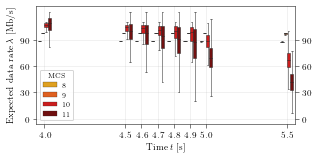

In [13]:
plt.rcParams.update({'figure.figsize': (2 * COLUMN_WIDTH * (2 / 3) - 0.033, COLUMN_HIGHT)})

fig, ax = plt.subplots(1, 1)

# Plot boxplots
sns.boxplot(
    x="timestep", y="samples", hue="mcs", data=m_rates_samples,
    order=time_order, ax=ax, width=0.8, showfliers=False, palette=colors_jet[8:]
)
sns.boxplot(
    x="timestep", y="samples", hue="mcs", data=pred_rates_samples,
    order=time_order, ax=ax, width=0.8, showfliers=False, palette=colors_jet[8:]
)

# Label x and y axes
ax.set_xticks((ticks - 4) * 10)
ax.set_xticklabels(ticks);
ax.set_xlabel(r'Time $t$ [s]')
ax.set_ylabel(r'Expected data rate $\lambda$ [Mb/s]')
ax.set_yticks(rates_ticks[:-1])
ax.set_ylim(rates_ylim)
ax.tick_params('y', labelleft=True, left=True, labelright=True, right=True)
ax.set_axisbelow(True)
ax.grid()

# Modify legend
rates_legend = ax.get_legend_handles_labels()
ax.legend(rates_legend[0][:4], rates_legend[1][:4], title="MCS", loc='lower left')

# Adjust position
# bbox_xdelta = 0.1
# rates_new_bbox = ax.get_position().get_points()
# rates_new_bbox[0, 0] += bbox_xdelta
# ax.set_position(Bbox(rates_new_bbox))

# Save figure
plt.savefig("rates_bars.pdf", bbox_inches='tight')

## Draft